# <font color=green> ProComp Data </font>

In [1]:
# Author: Ramon E. Diaz-Ramos <a01133921@itesm.mx>

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # For plots
import seaborn as sns

import os # To select the working directory and export files for weather in that directory
from glob import glob # To find files recursively

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA

In [2]:
class ResilienceStressIndex():

    def __init__(self, folderName):
        self.folderName = folderName
        self.df_pc_ = self.importdata()
        self.df_pca_ = []
        self.df_pca_centroids_ = []
        self.distances_ = []

    
    def importdata(self):
        # Set working directory
        os.chdir(self.folderName)
        # Import all cases from the text files
        filenames = glob('caso*.txt')
        df_pc = [pd.read_csv(f, sep=',', skiprows=6, encoding = 'ISO-8859-1', low_memory=False) for f in filenames]
        # Add an identifier to each dataframe
        for element in range(len(df_pc)):
            df_pc[element]['Subject'] = 'case'+str(element)
            df_pc[element].drop(df_pc[element].index[0], inplace=True)
        os.chdir('..') # Return to the working directory

        return df_pc

    def plot_freq(self, data_num, groups=[1,2,3,4,5]):
        values = self.df_pc_[data_num].values
        i = 1
        # plot each column
        plt.figure(figsize=(10, 8))
        for group in groups:
            plt.subplot(len(groups), 1, i)
            plt.plot(values[:, group])
            plt.title(self.df_pc_[data_num].columns[group], y=0.5, loc='right')
            i += 1
        plt.show()

        return None
    
    def resampling_df(self, decimals):
        # Change type string to float
        for i in range(len(self.df_pc_)):
            self.df_pc_[i]['Time'] = self.df_pc_[i]['Time'].astype('float64')
            # Create a column that rounds the time
            self.df_pc_[i]['rounded_Time'] = self.df_pc_[i]['Time'].round(decimals=decimals)
            # Group all columns by the rounded time with the median (as there are outliers in data)
            self.df_pc_[i] = self.df_pc_[i].groupby('rounded_Time', as_index=False).median()
            # Drop Time column
            self.df_pc_[i] = self.df_pc_[i].drop('Time', axis=1)
            # Rename the rounded time column to Time
            self.df_pc_[i].rename(columns={'rounded_Time':'Time'}, inplace=True)
            # Transform it to int type
            self.df_pc_[i]['Time'] = self.df_pc_[i].astype('int')
        
        return self
    
    def add_phase_column(self):
        # Add a phase feature that indicates the phase it belongs
        for element in range(len(self.df_pc_)):
            self.df_pc_[element]['Phase'] = 0
            phase = range(1, self.df_pc_[element].shape[0]//120+1)
            i = 0
            for phases in phase:
                if i == 0:
                    self.df_pc_[element].loc[self.df_pc_[element]['Time'] >= i, 'Phase'] = 'phase'+str(phases)
                else:
                    self.df_pc_[element].loc[self.df_pc_[element]['Time'] > i, 'Phase'] = 'phase'+str(phases)
                i += 120
        
        return self
    
    def homologate_names(self):
        # C: SC it is the same as D: Conductancia de la piel
        # A: BVP = B: Volumen del pulso sanguineo
        # B: Temp = E: Temperatura
        # D: RA = C: Respiracion
        # E: RT = A: Electromiografia
        for element in range(len(self.df_pc_)):
            self.df_pc_[element] = self.df_pc_[element].rename(columns={'C: SC':'Skin_Conductance','D: Conductancia de la piel':'Skin_Conductance','A: BVP':'Blood_Volume','B: Volumen del pulso sanguineo':'Blood_Volume','B: Temp':'Corporal_Temperature','E: Temperatura':'Corporal_Temperature','D: RA':'Breathing','C: Respiracion':'Breathing','E: RT':'Electromyography','A: Electromiografia':'Electromyography'})
        return self

    def fit_scaler(self, scaler_=StandardScaler()):
        # Features to scale
        features = ['Electromyography', 'Blood_Volume', 'Breathing', 'Skin_Conductance', 'Corporal_Temperature']
        # Concatenate complete dataframe
        df_all = pd.concat(self.df_pc_)
        # Separating out the features
        X = df_all.loc[:, features].values
        self.scaler_ = scaler_
        self.scaler_.fit(X)

        return self

    def create_pca(self):

        for element in range(len(self.df_pc_)):
            # Features to scale
            features = ['Electromyography', 'Blood_Volume', 'Breathing', 'Skin_Conductance', 'Corporal_Temperature']
            # Separating out the features
            x = self.df_pc_[element].loc[:, features].values
            # Standardizing the features
            x = self.scaler_.transform(x)
            # Transform for linearity with power transformation
            pt = PowerTransformer(method='yeo-johnson', standardize=True)
            x = pt.fit_transform(x)
            # Creating the PCA
            pca = PCA(n_components=2, random_state=10)
            # Fitting and transforming the data
            principalComponents = pca.fit_transform(x)
            # Creating Dataframe of transformed data
            principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
            # Concatenate the phase data
            finalDf = pd.concat([principalDf, self.df_pc_[element]['Phase']], axis=1)
            self.df_pca_.append(finalDf)
            print('Subject: '+str(element))
            print(pca.explained_variance_ratio_)

        return self

    def calculate_centroids_pca(self):
        for element in range(len(self.df_pca_)):
            self.df_pca_centroids_.append(self.df_pca_[element].groupby(by='Phase', as_index=False).mean())
        
        return self

    def plot_pca(self, subject):
        # Create layer for 2D Graph
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1) 
        ax.set_xlabel('PC1', fontsize = 15)
        ax.set_ylabel('PC2', fontsize = 15)
        #ax.set_title('PCA of Subject', fontsize = 20)
        # Plot
        targets = self.df_pca_[subject].Phase.unique()
        for target in targets:
            indicesToKeep = self.df_pca_[subject]['Phase'] == target
            ax.scatter(self.df_pca_[subject].loc[indicesToKeep, 'PC1']
                    , self.df_pca_[subject].loc[indicesToKeep, 'PC2']
                    , s = 50)
        ax.legend(targets)
        ax.grid()

        return None
    
    def plot_pca_centroid(self, subject):
        # Create layer for 2D Graph
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1) 
        ax.set_xlabel('PC1', fontsize = 15)
        ax.set_ylabel('PC2', fontsize = 15)
        #ax.set_title('PCA of Centroids of Subject: '+str(subject), fontsize = 20)
        # Plot
        targets = self.df_pca_centroids_[subject].Phase.unique()
        for target in targets:
            indicesToKeep = self.df_pca_centroids_[subject]['Phase'] == target
            ax.scatter(self.df_pca_centroids_[subject].loc[indicesToKeep, 'PC1']
                    , self.df_pca_centroids_[subject].loc[indicesToKeep, 'PC2']
                    , s = 50)
        ax.legend(targets)
        ax.grid()

        return None        

    def rotate_translate_axis(self):
        '''
        The function translate the first phase to the origin and rotates the second phase with the positive x-axis for centroids.
        '''
        for subject in range(len(self.df_pca_)):
            # First translation
            x = self.df_pca_[subject].PC1.loc[0]
            y = self.df_pca_[subject].PC2.loc[0]
            self.df_pca_[subject]['PC1'] = self.df_pca_[subject]['PC1'] - x
            self.df_pca_[subject]['PC2'] = self.df_pca_[subject]['PC2'] - y
            # Now get the rotation angle in rad where np.arctan(y, x) gives you the angle of rotation for all points to the positive x-axis
            angle = np.arctan2(self.df_pca_[subject].PC2.loc[1], self.df_pca_[subject].PC1.loc[1])
            for i in range(1,self.df_pca_[subject].shape[0]):
                # Calculate the new points of rotation with x'=x*cos(angle)-y*sin(angle) and y'= y*cos(angle)+x*sin(angle)
                x_ = self.df_pca_[subject].PC1.loc[i]
                y_ = self.df_pca_[subject].PC2.loc[i]
                self.df_pca_[subject].PC1.loc[i] = x_*np.cos(-1*angle)-y_*np.sin(-1*angle)
                self.df_pca_[subject].PC2.loc[i] = round(y_*np.cos(-1*angle),15)+round(x_*np.sin(-1*angle),15)

        return self

    # Calculate the euclidean distance
    def euclidean_distance(self):
        distances_list = []
        for subject in range(len(self.df_pca_centroids_)):
            distances_list.append([np.sqrt((self.df_pca_centroids_[subject].PC1[0]-self.df_pca_centroids_[subject].PC1[element])**2+(self.df_pca_centroids_[subject].PC2[0]-self.df_pca_centroids_[subject].PC2[element])**2) for element in range(1, len(self.df_pca_centroids_[subject]))])
        # This will get you the dataframe
        self.distances_ = pd.DataFrame(data=distances_list, columns=['Ph1-Ph2','Ph1-Ph3','Ph1-Ph4','Ph1-Ph5','Ph1-Ph6'])

        return self

    def maximum_stressor_factor(self):
        '''
        Calculates the maximum stressor factor of the sample based on the population parameter
        '''
        try:
            pop_max_stressor = self.distances_['Max_Delta_Stress'].max()
            for subject in range(len(self.distances_)):
                self.distances_['maximum_stressor_factor'] = self.distances_['Max_Delta_Stress']/pop_max_stressor
        except KeyError:
            print('Key Error: the maximum stress delta value of the samples is not calculated yet, try running the method "calculate_index" first.')
        return self

In [3]:
model = ResilienceStressIndex('ProComp')

In [4]:
len(model.df_pc_)

134

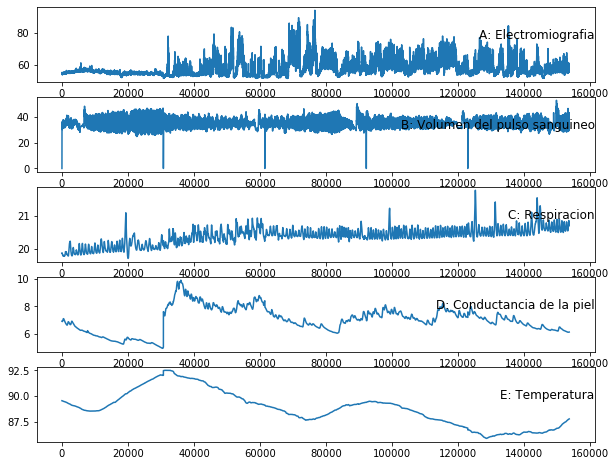

In [5]:
model.plot_freq(data_num=1)

## **Resampling of data**

In [6]:
# Resampling the data once
model.resampling_df(decimals=0)
# Adding the phase column
model.add_phase_column()
# Homologate column names
model.homologate_names()

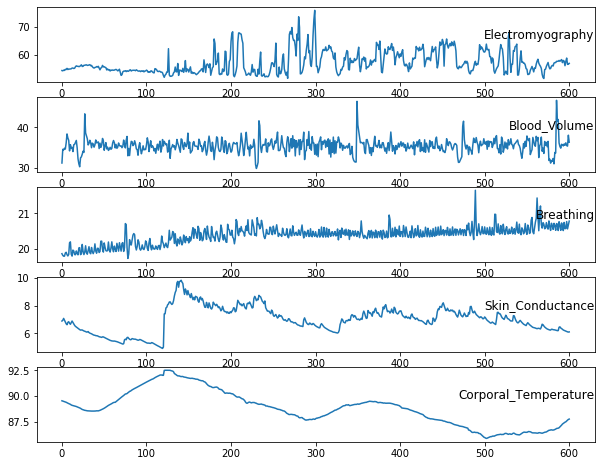

In [7]:
model.plot_freq(1, groups=[1,2,3,4,5])

## **PCA**

There are assumptions that need to comply to apply PCA correctly:

- Assumption #1: You have multiple variables that should be measured at the continuous level (although ordinal variables are very frequently used). Examples of continuous variables (i.e., ratio or interval variables) include revision time (measured in hours), intelligence (measured using IQ score), exam performance (measured from 0 to 100), weight (measured in kg), and so forth. Examples of ordinal variables commonly used in PCA include a wide range o f Likert scales (e.g., a 7-point scale from 'strongly agree' through to 'strongly disagree'; a 5-point scale from 'never' to 'always'; a 7-point scale from 'not at all' to 'very much'; a 5-point scale from 'not important' to 'extremely important').
    
- Assumption #2: There needs to be a linear relationship between all variables. The reason for this assumption is that a PCA is based on Pearson correlation coefficients, and as such, there needs to be a linear relationship between the variables. In practice, this assumption is somewhat relaxed (even if it shouldn't be) with the use of ordinal data for variables. Although linearity can be tested using a matrix scatterplot, this is often considered overkill because the scatterplot can sometimes have over 500 linear relationships. As such, it is suggested that you randomly select just a few possible relationships between variables and test these. You can check for linearity in SPSS Statistics using scatterplots, and where there are non-linear relationships, try and "transform" these. If you choose to upgrade to our enhanced content, we have SPSS Statistics guides that show you how to test for linearity using SPSS Statistics, as well as how to carry out transformations when this assumption is violated. You can learn more about our enhanced content on our Features: Overview page.

- Assumption #3: You should have sampling adequacy, which simply means that for PCA to produce a reliable result, large enough sample sizes are required. Many different rules-of-thumb have been proposed. These mainly differ depending on whether an absolute sample size is proposed or if a multiple of the number of variables in your sample are used. Generally speaking, a minimum of 150 cases, or 5 to 10 cases per variable, has been recommended as a minimum sample size. There are a few methods to detect sampling adequacy: (1) the Kaiser-Meyer-Olkin (KMO) Measure of Sampling Adequacy for the overall data set; and (2) the KMO measure for each individual variable. In the SPSS Statistics procedure later in this guide, we show you which options to select in SPSS Statistics to test for sampling adequacy. If you are unsure how to interpret the results from these tests, we show you in our enhanced PCA guide, which is part of our enhanced content (again, you can learn more about our enhanced content on our Features: Overview page).

- Assumption #4: Your data should be suitable for data reduction. Effectively, you need to have adequate correlations between the variables in order for variables to be reduced to a smaller number of components. The method used by SPSS Statistics to detect this is Bartlett's test of sphericity. Interpretation of this test is provided as part of our enhanced PCA guide.

- Assumption #5: There should be no significant outliers. Outliers are important because these can have a disproportionate influence on your results. SPSS Statistics recommends determining outliers as component scores greater than 3 standard deviations away from the mean. Again, in the SPSS Statistics procedure later in this guide, we show you which options to select in SPSS Statistics to check for outliers. If you are unsure how to interpret the SPSS Statistics output that you need to inspect to check for outliers, we show you in our enhanced PCA guide.

https://statistics.laerd.com/spss-tutorials/principal-components-analysis-pca-using-spss-statistics.php 

In [8]:
model.fit_scaler()

In [9]:
model.scaler_

StandardScaler()

In [10]:
model.df_pc_[3]

,Time,Electromyography,Blood_Volume,Breathing,Skin_Conductance,Corporal_Temperature,Phase
0,0,43.594,34.1035,10.490,4.499,74.033,phase1
1,1,44.474,35.2480,10.988,4.492,74.023,phase1
2,2,44.423,34.8020,10.769,4.477,74.016,phase1
3,3,44.371,34.6200,10.721,4.468,74.024,phase1
4,4,44.630,34.5890,10.442,4.459,74.032,phase1
...,...,...,...,...,...,...,...
596,596,41.056,34.6320,10.791,4.370,73.562,phase5
597,597,40.590,34.8990,10.727,4.363,73.578,phase5
598,598,40.797,34.9070,11.288,4.355,73.578,phase5
599,599,41.367,35.0150,10.869,4.349,73.579,phase5


In [11]:
model.create_pca()

Subject: 0
[0.40963032 0.22249447]
Subject: 1
[0.34096577 0.23723704]
Subject: 2
[0.39950963 0.26167519]
Subject: 3
[0.28397245 0.23414768]
Subject: 4
[0.41915105 0.20509773]
Subject: 5
[0.35486044 0.21096736]
Subject: 6
[0.36867902 0.25584745]
Subject: 7
[0.26661452 0.24453754]
Subject: 8
[0.25379019 0.23241138]
Subject: 9
[0.36701982 0.27486577]
Subject: 10
[0.32893613 0.25816374]
Subject: 11
[0.60506768 0.26089324]
Subject: 12
[0.35323806 0.29515096]
Subject: 13
[0.35430952 0.2205007 ]
Subject: 14
[0.39678981 0.29542902]
Subject: 15
[0.42158798 0.34976482]
Subject: 16
[0.51893928 0.48106072]
Subject: 17
[0.52507368 0.47492632]
Subject: 18
[0.39056708 0.33539555]
Subject: 19
[0.58411492 0.23318139]
Subject: 20
[0.57813531 0.23598568]
Subject: 21
[0.41346986 0.27187351]
Subject: 22
[0.33111668 0.29031702]
Subject: 23
[0.61495209 0.25050349]
Subject: 24
[0.45172147 0.25735857]
Subject: 25
[0.66500132 0.25262989]
Subject: 26
[0.43763058 0.25368969]
Subject: 27
[0.47125835 0.26018612]
Su

In [12]:
model.df_pca_[2]

,PC1,PC2,Phase
0,-2.033761,0.120033,phase1
1,-2.110078,-0.839614,phase1
2,-2.201762,-2.340115,phase1
3,-2.195881,-2.228578,phase1
4,-2.104990,-0.993339,phase1
...,...,...,...
596,-1.667243,1.281777,phase5
597,-1.723002,0.743973,phase5
598,-1.771744,0.303669,phase5
599,-1.794459,0.500020,phase5


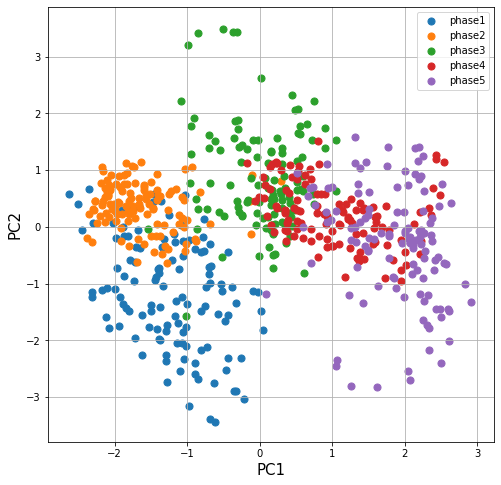

In [13]:
model.plot_pca(subject=0)

In [14]:
model.calculate_centroids_pca()

In [15]:
model.df_pca_centroids_[0]

,Phase,PC1,PC2
0,phase1,-1.233016,-1.155155
1,phase2,-1.635730,0.367421
2,phase3,0.030701,0.859560
3,phase4,1.016373,0.225957
4,phase5,1.831946,-0.288157


Ploting one subject pca centroids of each phase

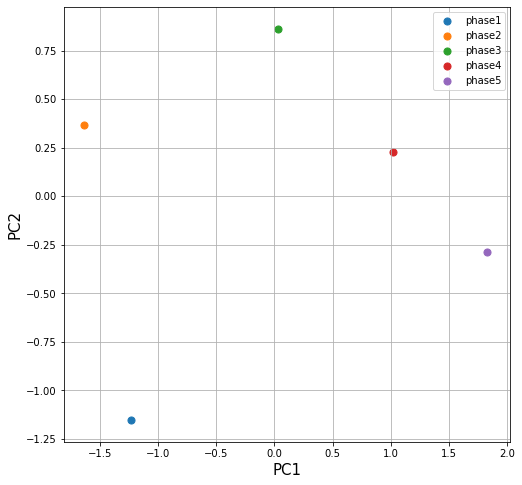

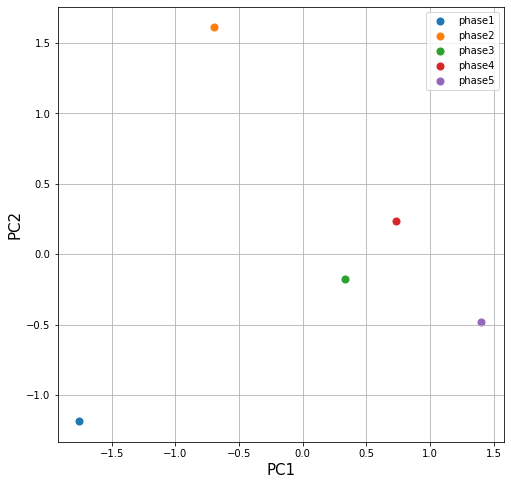

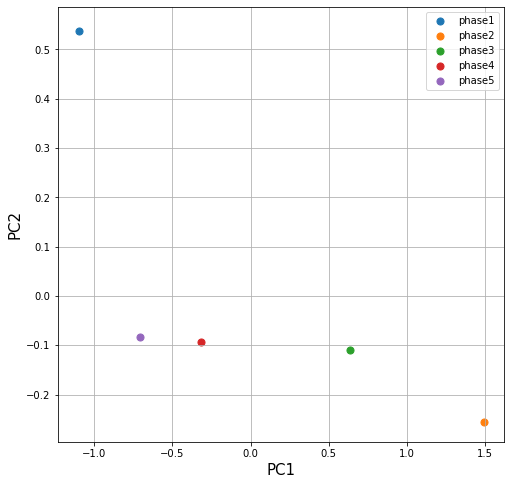

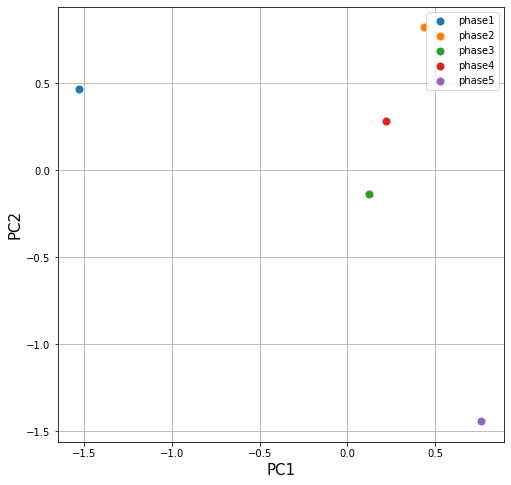

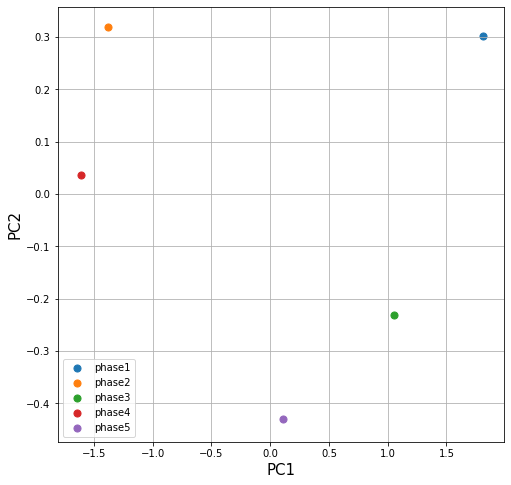

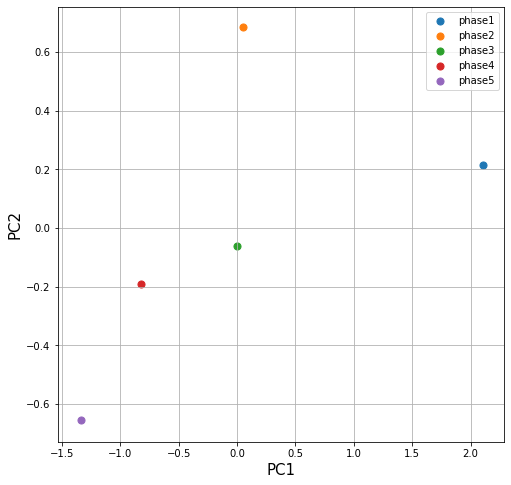

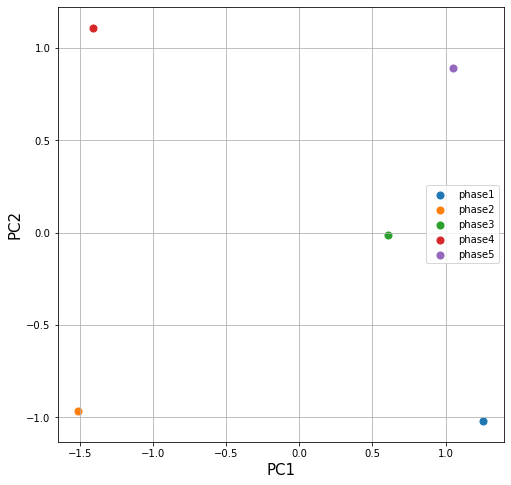

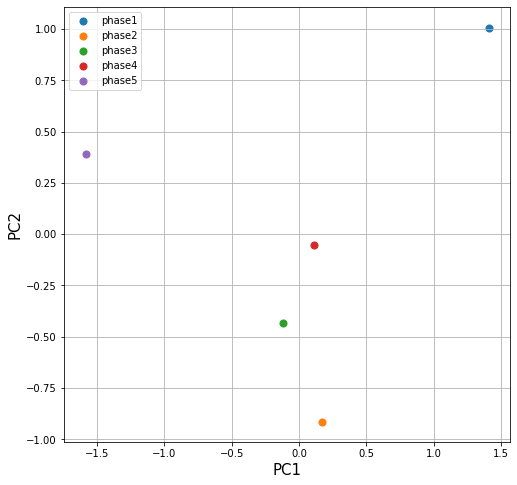

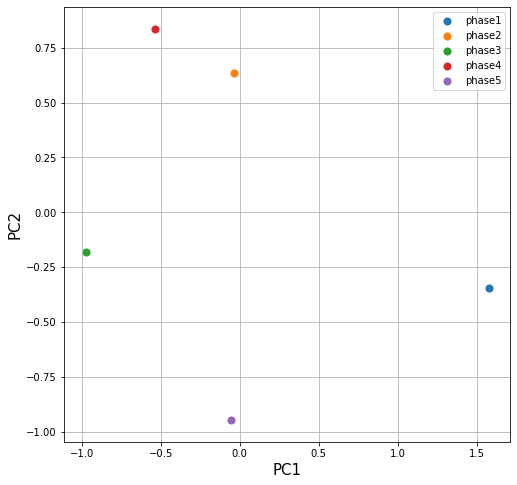

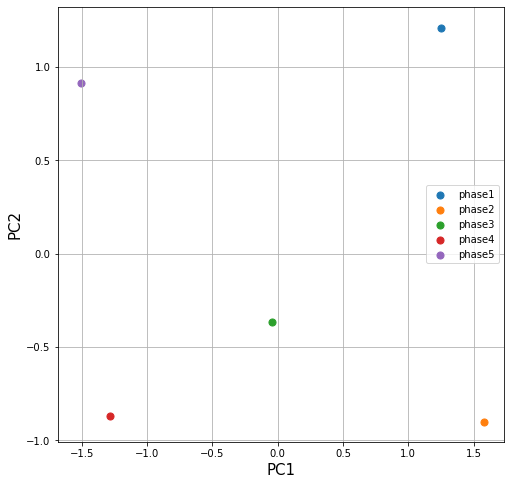

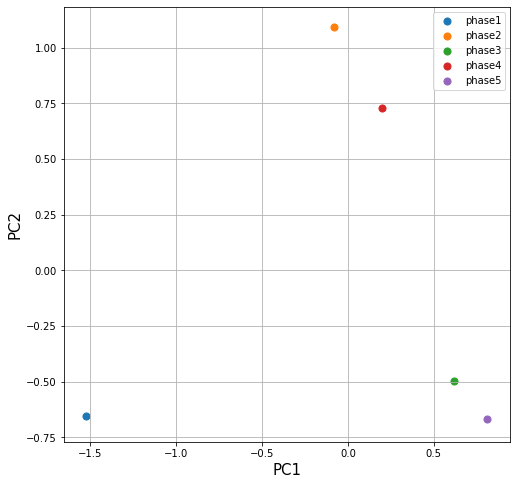

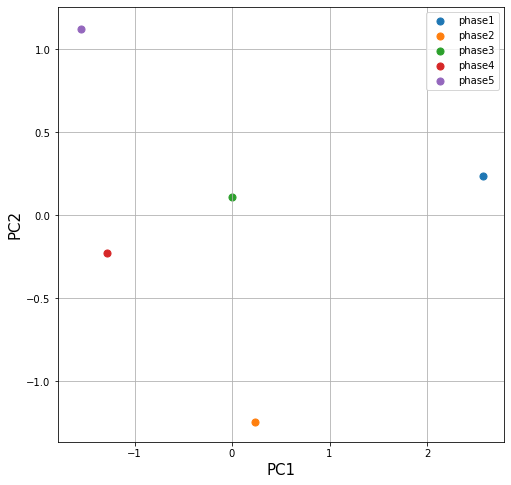

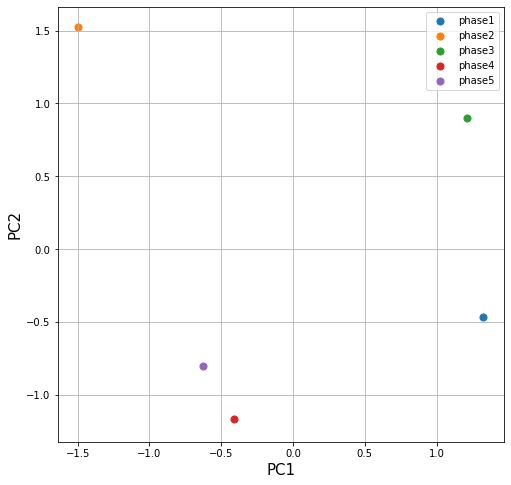

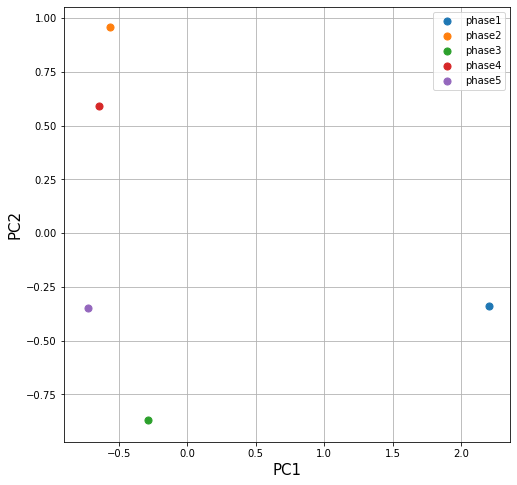

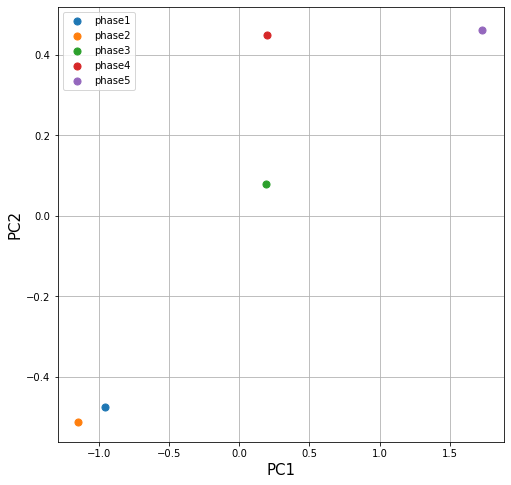

In [16]:
for i in range(15):
    model.plot_pca_centroid(i)

Now we can calculate the distances

## Calculating distances

In [17]:
model.euclidean_distance()

In [18]:
model.distances_

,Ph1-Ph2,Ph1-Ph3,Ph1-Ph4,Ph1-Ph5,Ph1-Ph6
0,1.574934,2.378247,2.639549,3.185228,NaN
1,2.992982,2.321618,2.867911,3.234079,NaN
2,2.702821,1.849856,0.999694,0.733611,NaN
3,2.000922,1.758407,1.757577,2.977320,NaN
4,3.190430,0.921849,3.429747,1.853040,NaN
...,...,...,...,...,...
129,1.587960,3.475900,3.885840,4.395770,NaN
130,2.155925,2.629328,3.299435,1.340727,NaN
131,3.230608,1.876110,2.878351,2.586924,NaN
132,0.372792,1.019295,0.650926,1.182143,NaN


In [19]:
import seaborn as sns

def calculate_index(distances):
    distances['Max_Delta_Stress'] = np.nan
    distances['Recovery_Delta_Last_Phase'] = np.nan
    distances['Resilience_Index'] = np.nan
    # Calculate of maximum point of stress before the last stressor phase and get the recovery phase delta
    for element in range(distances.shape[0]):
        if pd.isnull(distances['Ph1-Ph6'].loc[element]) == True:
            if pd.isnull(distances['Ph1-Ph5'].loc[element]) == True:
                if pd.isnull(distances['Ph1-Ph4'].loc[element]) == True:
                    distances['Max_Delta_Stress'].loc[element] = distances['Ph1-Ph2'].loc[element]
                    distances['Recovery_Delta_Last_Phase'].loc[element] = distances['Ph1-Ph3'].loc[element]
            else:
                distances['Max_Delta_Stress'].loc[element] = distances[['Ph1-Ph2','Ph1-Ph4']].loc[element].max()
                distances['Recovery_Delta_Last_Phase'].loc[element] = distances['Ph1-Ph5'].loc[element]
        else:
            distances['Max_Delta_Stress'].loc[element] = distances[['Ph1-Ph2','Ph1-Ph4']].loc[element].max()
            distances['Recovery_Delta_Last_Phase'].loc[element] = distances['Ph1-Ph6'].loc[element]
    # Get the resilience index, the more positive the better resilience to stress.
    distances['Resilience_Index'][(distances['Max_Delta_Stress'] != distances['Recovery_Delta_Last_Phase'])] = distances['Max_Delta_Stress']-distances['Recovery_Delta_Last_Phase']
    distances['Resilience_Index'][(distances['Max_Delta_Stress'] == distances['Recovery_Delta_Last_Phase'])] = -1*distances['Recovery_Delta_Last_Phase']

    sns.distplot(distances['Resilience_Index'], hist=True, kde=True, color='darkblue',hist_kws={'edgecolor':'black'})
    plt.title('Density Plot and Histogram of Resilience Index')
    plt.ylabel('Density')
    plt.xlabel('Resilience Index')
    plt.show()

    sns.boxplot(x='Resilience_Index', orient='h',data=distances)
    plt.title('Boxplot of Resilience Index')
    plt.show()

    return distances

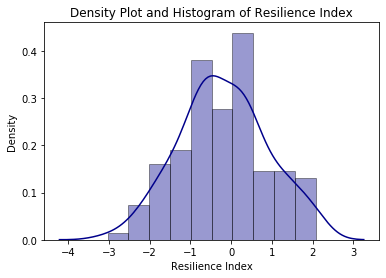

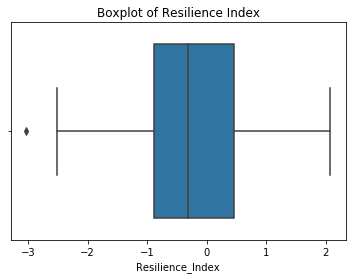

,Ph1-Ph2,Ph1-Ph3,Ph1-Ph4,Ph1-Ph5,Ph1-Ph6,Max_Delta_Stress,Recovery_Delta_Last_Phase,Resilience_Index
0,1.574934,2.378247,2.639549,3.185228,NaN,2.639549,3.185228,-0.545679
1,2.992982,2.321618,2.867911,3.234079,NaN,2.992982,3.234079,-0.241098
2,2.702821,1.849856,0.999694,0.733611,NaN,2.702821,0.733611,1.969210
3,2.000922,1.758407,1.757577,2.977320,NaN,2.000922,2.977320,-0.976397
4,3.190430,0.921849,3.429747,1.853040,NaN,3.429747,1.853040,1.576707
...,...,...,...,...,...,...,...,...
129,1.587960,3.475900,3.885840,4.395770,NaN,3.885840,4.395770,-0.509929
130,2.155925,2.629328,3.299435,1.340727,NaN,3.299435,1.340727,1.958708
131,3.230608,1.876110,2.878351,2.586924,NaN,3.230608,2.586924,0.643684
132,0.372792,1.019295,0.650926,1.182143,NaN,0.650926,1.182143,-0.531218


In [20]:
regular_index = calculate_index(model.distances_)
regular_index

In [21]:
def calculate_index_recovery_factor(distances):
    '''
    Calculates an index value between 0 and 1, the closer to 0 the worst, the closer to 1 the more resilient.
    '''
    # Initialize column variables
    distances['Max_Delta_Stress'] = np.nan
    distances['Recovery_Delta_Last_Phase'] = np.nan
    distances['Resilience_Index'] = np.nan   
    # Calculate the max delta stress of each individual and its recovery delta of the last recovery phase
    for element in range(distances.shape[0]):
        if pd.isnull(distances['Ph1-Ph6'].loc[element]) == True:
            if pd.isnull(distances['Ph1-Ph5'].loc[element]) == True:
                if pd.isnull(distances['Ph1-Ph4'].loc[element]) == True:
                    distances['Max_Delta_Stress'].loc[element] = distances['Ph1-Ph2'].loc[element]
                    distances['Recovery_Delta_Last_Phase'].loc[element] = distances['Ph1-Ph3'].loc[element]
            else:
                distances['Max_Delta_Stress'].loc[element] = distances[['Ph1-Ph2','Ph1-Ph4']].loc[element].max()
                distances['Recovery_Delta_Last_Phase'].loc[element] = distances['Ph1-Ph5'].loc[element]
        else:
            distances['Max_Delta_Stress'].loc[element] = distances[['Ph1-Ph2','Ph1-Ph4']].loc[element].max()
            distances['Recovery_Delta_Last_Phase'].loc[element] = distances['Ph1-Ph6'].loc[element]
    # Get the maximum value of the population of delta stress
    population_max_delta_stress = distances['Max_Delta_Stress'].max()
    # Get the resilience index, the more positive the better resilience to stress.
    distances['Resilience_Index'] = distances['Max_Delta_Stress']**2/(population_max_delta_stress*distances['Recovery_Delta_Last_Phase'])

    print('Population_Max_Delta_Stress: %.4f'%(population_max_delta_stress))
    sns.distplot(distances['Resilience_Index'], hist=True, kde=True, color='darkblue',hist_kws={'edgecolor':'black'})
    plt.title('Density Plot and Histogram of Resilience Index')
    plt.ylabel('Density')
    plt.xlabel('Resilience Index')
    plt.show()

    sns.boxplot(x='Resilience_Index', orient='h',data=distances)
    plt.title('Boxplot of Resilience Index')
    plt.show()


    return distances

Population_Max_Delta_Stress: 4.9854


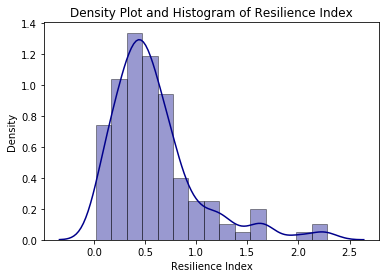

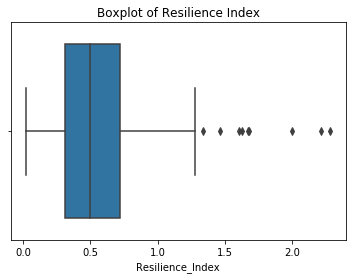

,Ph1-Ph2,Ph1-Ph3,Ph1-Ph4,Ph1-Ph5,Ph1-Ph6,Max_Delta_Stress,Recovery_Delta_Last_Phase,Resilience_Index
0,1.574934,2.378247,2.639549,3.185228,NaN,2.639549,3.185228,0.438750
1,2.992982,2.321618,2.867911,3.234079,NaN,2.992982,3.234079,0.555591
2,2.702821,1.849856,0.999694,0.733611,NaN,2.702821,0.733611,1.997408
3,2.000922,1.758407,1.757577,2.977320,NaN,2.000922,2.977320,0.269732
4,3.190430,0.921849,3.429747,1.853040,NaN,3.429747,1.853040,1.273320
...,...,...,...,...,...,...,...,...
129,1.587960,3.475900,3.885840,4.395770,NaN,3.885840,4.395770,0.689022
130,2.155925,2.629328,3.299435,1.340727,NaN,3.299435,1.340727,1.628685
131,3.230608,1.876110,2.878351,2.586924,NaN,3.230608,2.586924,0.809250
132,0.372792,1.019295,0.650926,1.182143,NaN,0.650926,1.182143,0.071894


In [22]:
recovery_factor = calculate_index_recovery_factor(model.distances_)
recovery_factor

In [23]:
recovery_factor.sort_values('Resilience_Index',axis=0,ascending=True)

,Ph1-Ph2,Ph1-Ph3,Ph1-Ph4,Ph1-Ph5,Ph1-Ph6,Max_Delta_Stress,Recovery_Delta_Last_Phase,Resilience_Index
70,0.100104,0.097351,NaN,NaN,NaN,0.100104,0.097351,0.020647
75,0.216265,0.838182,0.705673,2.876404,3.739833,0.705673,3.739833,0.026709
79,0.834205,1.480917,0.857362,2.836085,3.038018,0.857362,3.038018,0.048533
62,0.817718,2.351382,NaN,NaN,NaN,0.817718,2.351382,0.057040
132,0.372792,1.019295,0.650926,1.182143,NaN,0.650926,1.182143,0.071894
...,...,...,...,...,...,...,...,...
116,3.897975,1.074430,0.702309,1.821691,NaN,3.897975,1.821691,1.673021
112,1.831429,0.549729,3.571290,1.525458,NaN,3.571290,1.525458,1.677058
2,2.702821,1.849856,0.999694,0.733611,NaN,2.702821,0.733611,1.997408
61,2.649261,0.635457,NaN,NaN,NaN,2.649261,0.635457,2.215447


In [24]:
def calculate_index_modified(distances):
    distances['Max_Delta_Stress'] = np.nan
    distances['Recovery_Delta_Last_Phase'] = np.nan
    distances['Resilience_Index'] = np.nan
    # Calculate of maximum point of stress before the last stressor phase and get the recovery phase delta
    for element in range(distances.shape[0]):
        if pd.isnull(distances['Ph1-Ph6'].loc[element]) == True:
            if pd.isnull(distances['Ph1-Ph5'].loc[element]) == True:
                if pd.isnull(distances['Ph1-Ph4'].loc[element]) == True:
                    distances['Max_Delta_Stress'].loc[element] = distances['Ph1-Ph2'].loc[element]
                    distances['Recovery_Delta_Last_Phase'].loc[element] = distances['Ph1-Ph3'].loc[element]
            else:
                distances['Max_Delta_Stress'].loc[element] = distances[['Ph1-Ph2','Ph1-Ph4']].loc[element].max()
                distances['Recovery_Delta_Last_Phase'].loc[element] = distances['Ph1-Ph5'].loc[element]
        else:
            distances['Max_Delta_Stress'].loc[element] = distances[['Ph1-Ph2','Ph1-Ph4']].loc[element].max()
            distances['Recovery_Delta_Last_Phase'].loc[element] = distances['Ph1-Ph6'].loc[element]
    # Get the maximum value of the population of delta stress
    population_max_delta_stress = distances['Max_Delta_Stress'].max()
    # Get the resilience index, the more positive the better resilience to stress.
    distances['Resilience_Index'] = (distances['Max_Delta_Stress']-distances['Recovery_Delta_Last_Phase'])/population_max_delta_stress

    sns.distplot(distances['Resilience_Index'], hist=True, kde=True, color='darkblue',hist_kws={'edgecolor':'black'})
    plt.title('Density Plot and Histogram of Resilience Index')
    plt.ylabel('Density')
    plt.xlabel('Resilience Index')
    plt.show()

    sns.boxplot(x='Resilience_Index', orient='h',data=distances)
    plt.title('Boxplot of Resilience Index')
    plt.show()

    return distances

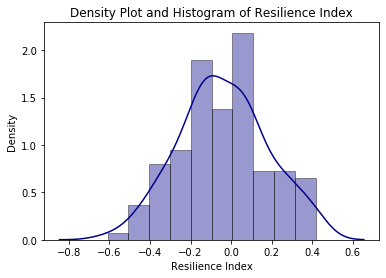

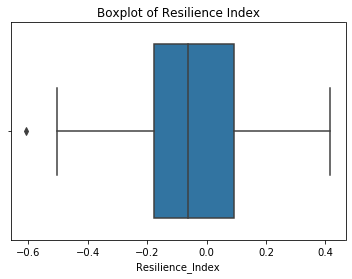

,Ph1-Ph2,Ph1-Ph3,Ph1-Ph4,Ph1-Ph5,Ph1-Ph6,Max_Delta_Stress,Recovery_Delta_Last_Phase,Resilience_Index
0,1.574934,2.378247,2.639549,3.185228,NaN,2.639549,3.185228,-0.109455
1,2.992982,2.321618,2.867911,3.234079,NaN,2.992982,3.234079,-0.048361
2,2.702821,1.849856,0.999694,0.733611,NaN,2.702821,0.733611,0.394994
3,2.000922,1.758407,1.757577,2.977320,NaN,2.000922,2.977320,-0.195850
4,3.190430,0.921849,3.429747,1.853040,NaN,3.429747,1.853040,0.316263
...,...,...,...,...,...,...,...,...
129,1.587960,3.475900,3.885840,4.395770,NaN,3.885840,4.395770,-0.102284
130,2.155925,2.629328,3.299435,1.340727,NaN,3.299435,1.340727,0.392887
131,3.230608,1.876110,2.878351,2.586924,NaN,3.230608,2.586924,0.129113
132,0.372792,1.019295,0.650926,1.182143,NaN,0.650926,1.182143,-0.106554


In [25]:
dist_modi = calculate_index_modified(model.distances_)
dist_modi

In [32]:
dist_modi.Max_Delta_Stress.max()

4.985421637426363

In [26]:
dist_modi.sort_values('Resilience_Index',axis=0,ascending=True)

,Ph1-Ph2,Ph1-Ph3,Ph1-Ph4,Ph1-Ph5,Ph1-Ph6,Max_Delta_Stress,Recovery_Delta_Last_Phase,Resilience_Index
75,0.216265,0.838182,0.705673,2.876404,3.739833,0.705673,3.739833,-0.608606
108,1.384693,1.759439,1.094140,3.664266,3.900031,1.384693,3.900031,-0.504539
43,0.385589,0.656487,1.509396,3.031208,3.909466,1.509396,3.909466,-0.481418
92,1.323418,1.815570,2.697424,3.626904,4.931406,2.697424,4.931406,-0.448103
79,0.834205,1.480917,0.857362,2.836085,3.038018,0.857362,3.038018,-0.437406
...,...,...,...,...,...,...,...,...
2,2.702821,1.849856,0.999694,0.733611,NaN,2.702821,0.733611,0.394994
61,2.649261,0.635457,NaN,NaN,NaN,2.649261,0.635457,0.403939
54,2.668249,3.086563,1.244464,1.487687,0.626090,2.668249,0.626090,0.409626
112,1.831429,0.549729,3.571290,1.525458,NaN,3.571290,1.525458,0.410363


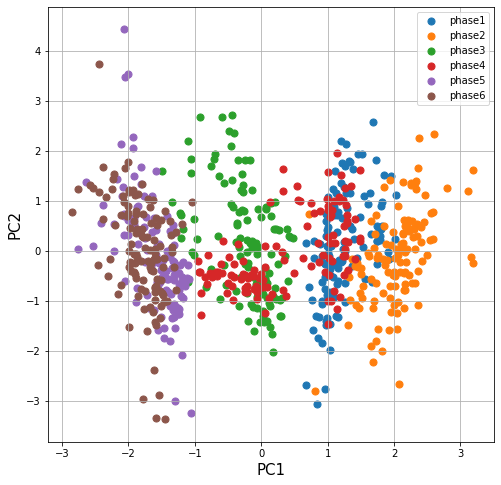

In [39]:
model.plot_pca(79)

Compara el 130 (buena resiliencia) y el 0 (estresado)

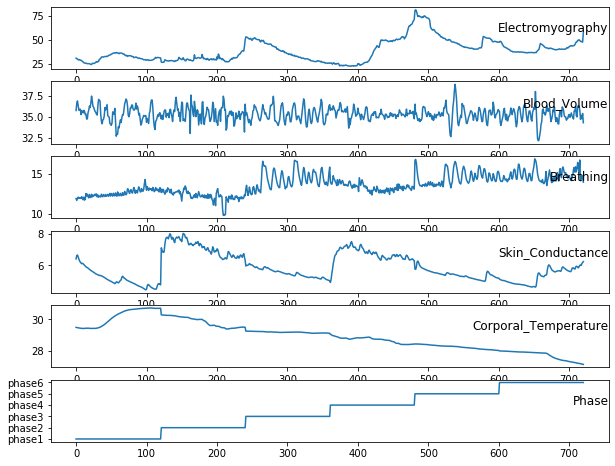

In [38]:
model.plot_freq(79, [1,2,3,4,5,6])

You need to consider that powertransformation does a normalization and that FIRST you need to transform then scale.